In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

starting of paralle.py
paralle.py/parallel is printing


In [2]:
df=pd.read_parquet('tezcatli_orders_data.parquet')

In [3]:
# top 3
# C+ St Plk         689915
# C+ St NT3         425402
# Pr Plk            403583

# region top
# Midwest East              124271
# Carolinas                 105971

In [4]:
def preprocess_data(df,region,forecast):
    df=df[df['Product Segment'].isin(['Exterior','Interior'])]
    df=df[df['Region Name']!='Export/Interco']
    df=df[df['Region Name']==region]
    df=df[df['forecast_group']==forecast]
    df=df[['Order Create Date','Order Volume (STD)']]
    df['Order Create Date']=pd.to_datetime(df['Order Create Date'])
    df=df.sort_values(by='Order Create Date')
    df=df.reset_index(drop=True)
    df['year'] = df['Order Create Date'].dt.year
    df['month'] = df['Order Create Date'].dt.month
    df = df.groupby(['year', 'month'])['Order Volume (STD)'].sum().reset_index()
    df['date']=df['year'].astype('string')+'-'+df['month'].astype('string')+'-01'
    df.set_index('date',inplace=True)
    df=df.drop(['year','month'],axis=1)
    df.index=pd.to_datetime(df.index)
    return df
# check stationary test dickey fuller test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [5]:
df=preprocess_data(df,'Midwest East','C+ St NT3')

In [6]:
adf_test(df['Order Volume (STD)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.162079
p-value                   0.942893
# lags used              11.000000
# observations          112.000000
critical value (1%)      -3.490131
critical value (5%)      -2.887712
critical value (10%)     -2.580730
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [7]:
adf_test(df['Order Volume (STD)'].diff(1).dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.989673e+00
p-value                 7.803524e-10
# lags used             1.000000e+01
# observations          1.120000e+02
critical value (1%)    -3.490131e+00
critical value (5%)    -2.887712e+00
critical value (10%)   -2.580730e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# data has seasonality and it is yearly seasonal

In [8]:
def allinOne_val(df,p,d,q):
    # df.plot()
    # sd=seasonal_decompose(df['Order Volume (STD)'])
    # sd.plot();
    # auto_arima_result=auto_arima(df['Order Volume (STD)'],seasonal=True).summary()
    # print('auto_arima_result',auto_arima_result)
    train=df[:'2021-12-01']
    val=df['2022-01-01':'2022-10-01']
    test=df['2022-11-01':]
    start=len(train)
    end=len(train) + len(val)-1
    model=SARIMAX(train['Order Volume (STD)'],order=(p, d, q))
    results=model.fit()
    predictions_val=results.predict(start,end).rename('SARIMAX  predict')
    val['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
    predictions_val.plot(legend=True)
    plt.show()
    print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(val['Order Volume (STD)'],predictions_val)*100)

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           42     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38117D+01    |proj g|=  1.02739D+00

At iterate    5    f=  1.32866D+01    |proj g|=  6.75204D-02

At iterate   10    f=  1.32668D+01    |proj g|=  1.78521D-02

At iterate   15    f=  1.32640D+01    |proj g|=  1.05312D-02

At iterate   20    f=  1.32632D+01    |proj g|=  1.81176D-02

At iterate   25    f=  1.32624D+01    |proj g|=  2.98305D-02

At iterate   30    f=  1.32607D+01    |proj g|=  2.50972D-02

At iterate   35    f=  1.32582D+01    |proj g|=  1.82790D-02

At iterate   40    f=  1.32556D+01    |proj g|=  3.42760D-02

At iterate   45    f=  1.32544D+01    |proj g|=  3.48690D-02

At iterate   50    f=  1.32540D+01    |proj g|=  9.59276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


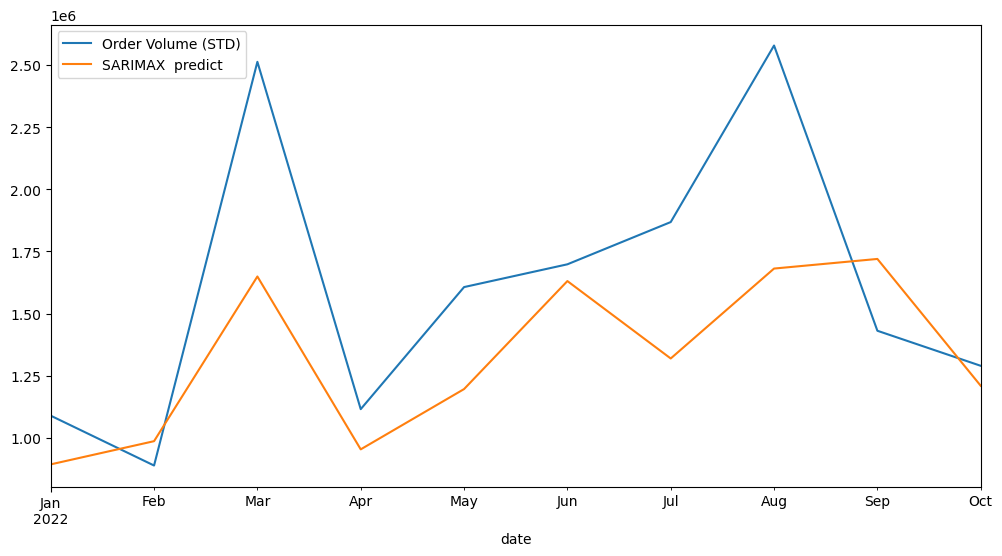

mean_absolute_percentage_error_val 19.825269556094817


In [9]:
allinOne_val(df,35,1,6)

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39738D+01    |proj g|=  8.74386D-02

At iterate    5    f=  1.39671D+01    |proj g|=  4.56446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   7.867D-07   1.397D+01
  F =   13.967059478409999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


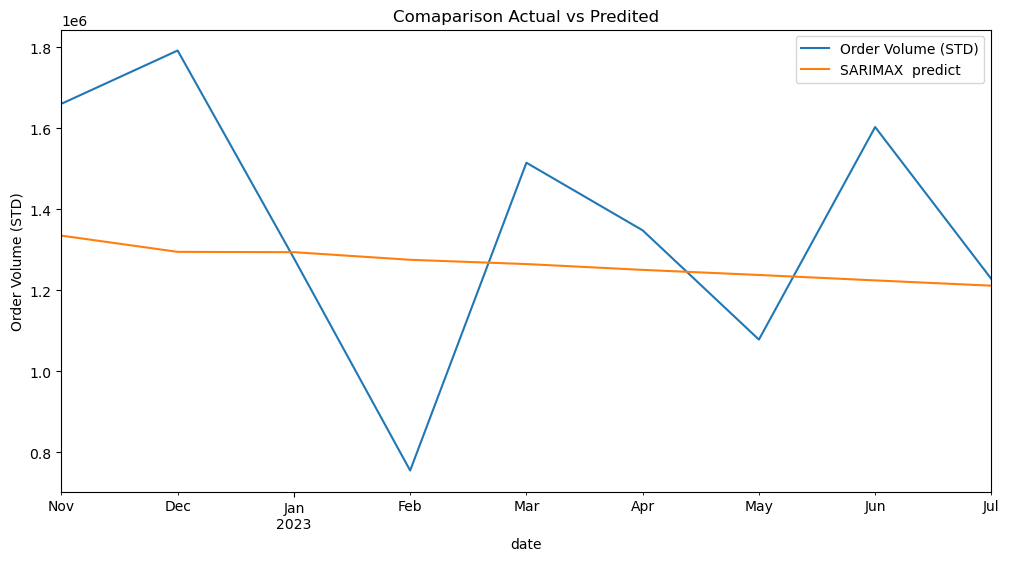

mean_absolute_percentage_error_val 20.09510149410066


In [26]:
train=df[:'2022-10-01']
# val=df[:'2022-10-01']
test=df['2022-11-01':]
start=len(train)
end=len(train) + len(test)-1
model=SARIMAX(train['Order Volume (STD)'],order=(1,2,1))
model.initialize_approximate_diffuse()
results=model.fit()
predictions=results.predict(start,end).rename('SARIMAX  predict')
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
predictions.plot(legend=True)
plt.ylabel('Order Volume (STD)')
plt.title('Comaparison Actual vs Predited')
plt.show()
print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions)*100)

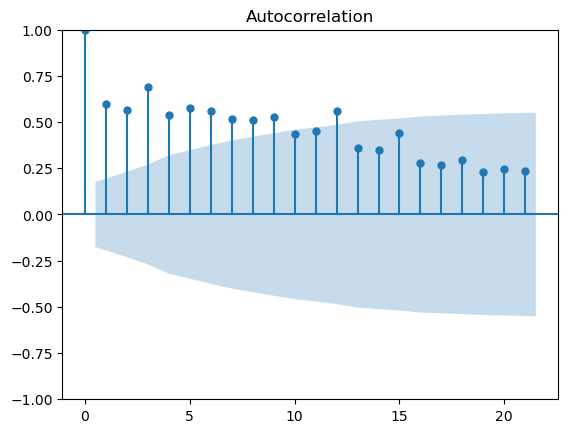

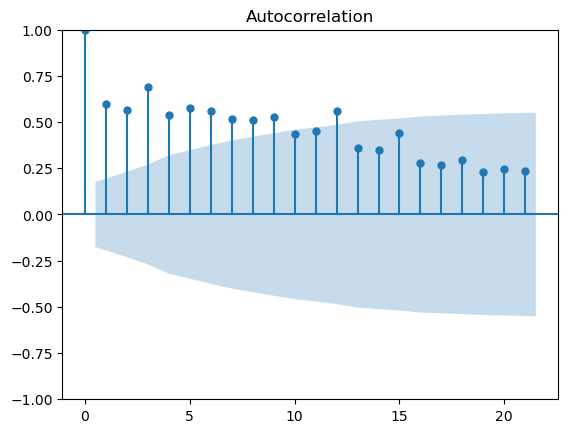

In [13]:
plot_acf(df)

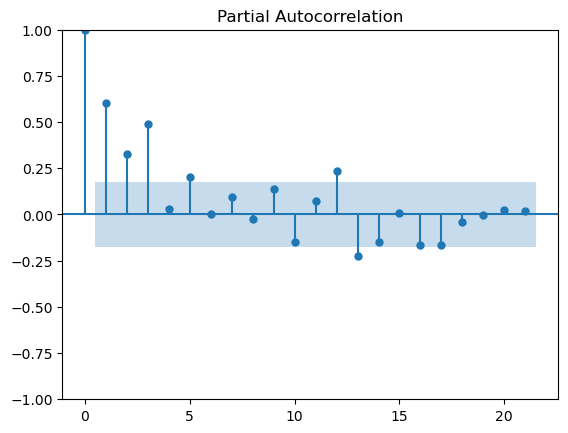

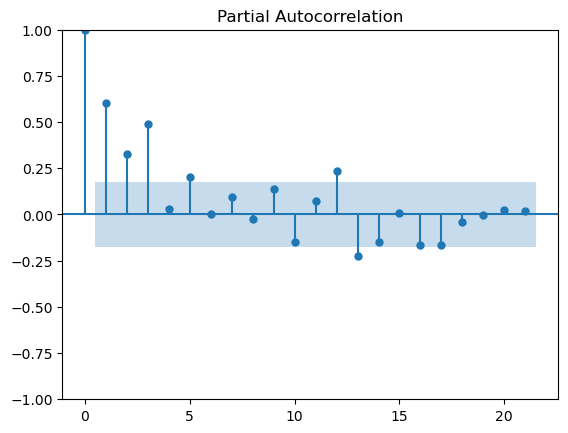

In [14]:
plot_pacf(df)

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27492D+02    |proj g|=  1.64643D+02

At iterate    5    f=  1.84099D+01    |proj g|=  2.84583D+00

At iterate   10    f=  1.40248D+01    |proj g|=  1.98640D+00

At iterate   15    f=  1.36869D+01    |proj g|=  7.55739D-01

At iterate   20    f=  1.34953D+01    |proj g|=  2.26354D-01

At iterate   25    f=  1.33963D+01    |proj g|=  1.03104D-01

At iterate   30    f=  1.33711D+01    |proj g|=  3.53535D-02

At iterate   35    f=  1.33431D+01    |proj g|=  5.43831D-02

At iterate   40    f=  1.33340D+01    |proj g|=  7.57588D-02

At iterate   45    f=  1.33227D+01    |proj g|=  5.43434D-02

At iterate   50    f=  1.33124D+01    |proj g|=  5.45489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/shahid/anaconda3/envs/jameshardie/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


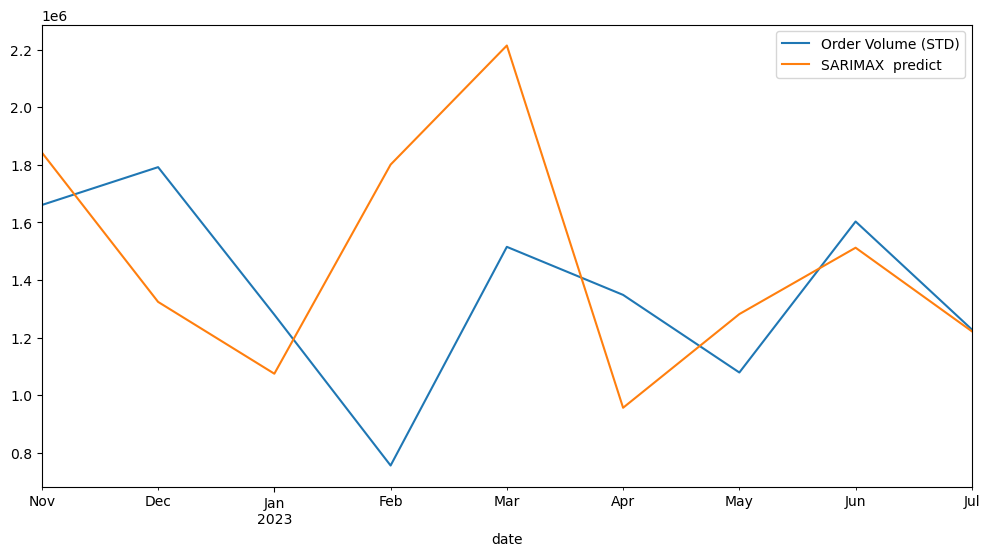

mean_absolute_percentage_error_val 32.428110765568604


In [99]:
train=df[:'2022-10-01']
# val=df[:'2022-10-01']
test=df['2022-11-01':]
start=len(train)
end=len(train) + len(test)-1
model=SARIMAX(train['Order Volume (STD)'],order=(23, 5, 6))
results=model.fit()
predictions=results.predict(start,end).rename('SARIMAX  predict')
test['Order Volume (STD)'].plot(figsize=(12,6),legend=True)
predictions.plot(legend=True)
plt.show()
print('mean_absolute_percentage_error_val',mean_absolute_percentage_error(test['Order Volume (STD)'],predictions)*100)

In [27]:
pd.DataFrame(predictions)

,SARIMAX predict
2022-11-01,1.335036e+06
2022-12-01,1.294961e+06
2023-01-01,1.294170e+06
2023-02-01,1.275363e+06
2023-03-01,1.264818e+06
2023-04-01,1.250484e+06
2023-05-01,1.237888e+06
2023-06-01,1.224495e+06
2023-07-01,1.211467e+06


In [28]:
test

,Order Volume (STD)
date,
2022-11-01,1660440.0
2022-12-01,1791893.2
2023-01-01,1279327.4
2023-02-01,755229.0
2023-03-01,1514983.0
2023-04-01,1348062.6
2023-05-01,1078404.0
2023-06-01,1603032.0
2023-07-01,1227935.4


### Final 

In [49]:
# model2=SARIMAX(train['Order Volume (STD)'],order=(10, 1, 10))
# results2=model2.fit()
# predictions2=results2.predict(start,end).rename('SARIMAX  predict')
# test['Order Volume (STD)'].plot(figsize=(12,6),legend=True,label='Order Volume (STD) Actual')
# predictions2.plot(legend=True)
# # plt.xticks('')
# plt.ylabel('Order Volume (STD)')
# plt.title('Comaparison Actual vs Predited')
# print('mean_absolute_error',mean_absolute_error(test['Order Volume (STD)'],predictions2))
# print("MAPE",mean_absolute_percentage_error(test['Order Volume (STD)'],predictions2))

In [ ]:
# import pandas as pd
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_absolute_error
# import matplotlib.pyplot as plt

# # Load your time series data into a pandas DataFrame
# # Replace this with your actual data loading code
# data = pd.read_csv('your_time_series_data.csv')

# # Choose the split points
# train_end = int(len(data) * 0.7)  # 70% for training
# val_end = int(len(data) * 0.85)   # 15% for validation, remaining for test

# # Split the data
# train = data[:train_end]
# validation = data[train_end:val_end]
# test = data[val_end:]

# # Fit the model on the training data
# model = SARIMAX(train['Order Volume (STD)'], order=(10, 1, 10))
# results = model.fit()

# # Make predictions on the validation set
# predictions_val = results.predict(start=len(train), end=len(train) + len(validation) - 1)

# # Calculate mean absolute error on the validation set
# mae_val = mean_absolute_error(validation['Order Volume (STD)'], predictions_val)
# print('Validation MAE:', mae_val)

# # Make predictions on the test set
# predictions_test = results.predict(start=len(train) + len(validation), end=len(data) - 1)

# # Calculate mean absolute error on the test set
# mae_test = mean_absolute_error(test['Order Volume (STD)'], predictions_test)
# print('Test MAE:', mae_test)

# # Plot the actual data, validation predictions, and test predictions
# plt.figure(figsize=(12, 6))
# data['Order Volume (STD)'].plot(label='Actual')
# predictions_val.plot(label='Validation Predictions')
# predictions_test.plot(label='Test Predictions')
# plt.legend()
# plt.title('SARIMA Model: Actual vs. Predicted')
# plt.xlabel('Time')
# plt.ylabel('Order Volume (STD)')
# plt.show()
